In [42]:
# --- Setup ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# Set seaborn style
sns.set(style="whitegrid")

# Load the data
df = pd.read_json("summary.jsonl", lines=True)

# Ensure numeric types
for col in ["average_time", "std_time", "average_peak_memory", "std_peak_memory",
            "average_net_memory_change", "std_net_memory_change", "energy_consumed_kWh"]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Create output directories
os.makedirs("figures", exist_ok=True)
os.makedirs("tables", exist_ok=True)


# ========== Section: Energy Consumption ==========

avg_energy_time = df.groupby("method")[["average_time", "energy_consumed_kWh"]].mean().reset_index()

plt.figure(figsize=(10, 7))
sns.scatterplot(data=avg_energy_time, x="average_time", y="energy_consumed_kWh", s=100)

for _, row in avg_energy_time.iterrows():
    plt.annotate(row["method"], (row["average_time"], row["energy_consumed_kWh"]),
                 textcoords="offset points", xytext=(5, 5), ha='left', fontsize=9)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Average Runtime (s, log scale)")
plt.ylabel("Average Energy Consumption (kWh, log scale)")
plt.title("Energy Consumption vs. Runtime (Log-Scale, Averaged by Method)")
plt.grid(True)
plt.tight_layout()
plt.savefig("figures/improved_runtime_vs_energy_scatter.png", dpi=300)
plt.close()

# ========== Section: Effect of Model Architecture ==========

plt.figure(figsize=(14, 6))
sns.barplot(data=df, x="model", y="average_time", hue="method")
plt.yscale("log")
plt.ylabel("Average Runtime (log scale, s)")
plt.title("Runtime per Model Architecture by XAI Method")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("figures/runtime_per_model_method.png", dpi=300)
plt.close()

# ========== Section: Impact of Dataset ==========

plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="dataset", y="average_time", hue="method")
plt.yscale("log")
plt.ylabel("Average Runtime (log scale, s)")
plt.title("Runtime by Dataset and XAI Method")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("figures/runtime_by_dataset.png", dpi=300)
plt.close()

# ========== Section: Impact of GPU Hardware ==========

plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="method", y="average_time", hue="gpu_name")
plt.yscale("log")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Average Runtime (log scale, s)")
plt.title("Runtime by XAI Method and GPU Hardware")
plt.tight_layout()
plt.savefig("figures/runtime_by_gpu.png", dpi=300)
plt.close()

# Energy table per GPU
energy_gpu = df.groupby(["method", "gpu_name"])["energy_consumed_kWh"].mean().unstack()
energy_gpu.T.to_latex("tables/energy_by_gpu.tex", float_format="%.5f")

In [16]:
# ========== PLOT: Log-Scaled Runtime by Method ==========

# Rename methods for readability
method_name_map = {
    "Grad_CAM": "Grad-CAM",
    "Grad_CAM_plus_plus": "Grad-CAM++",
    "Morris_Sensitivity_Analysis": "Morris Sensitivity Analysis",
    "GradientShap": "Gradient Shap",
    "IntegratedGradients": "Integrated Gradients",
    "PermutationImportance": "Permutation Importance",
    "DeepLiftShap": "DeepLift Shap",
    "InputXGradient": "Input × Gradient",
    "AblationStudies": "Ablation Studies",
    "GuidedBackprop": "Guided Backpropagation",
    "Saliency": "Saliency",
    "CAM": "CAM",
    "LIME": "LIME",
    "RISE": "RISE"
}

# Apply readable method names
df["method"] = df["method"].astype(str)
df["method_readable"] = df["method"].replace(method_name_map)

# Group by method and compute statistics
runtime_summary = (
    df.groupby("method_readable")["average_time"]
    .agg(["mean", "min", "max"])
    .round(2)
    .reset_index()
    .sort_values("mean", ascending=True)
)

# Sort runtime_summary just in case
# runtime_summary = runtime_summary.sort_values("mean", ascending=True)

# Apply renaming
runtime_summary_named = runtime_summary.copy()
runtime_summary_named["method_readable"] = runtime_summary_named.index.to_series().replace(method_name_map)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=runtime_summary_named, x="method_readable", y="mean", palette="viridis")
plt.yscale("log")
plt.xlabel("XAI Method")
plt.ylabel("Average Runtime (log scale, s)")
plt.title("Log-Scaled Average Runtime per XAI Method")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("figures/runtime_log_barplot.png", dpi=300)
plt.close()

/tmp/ipykernel_3303/2160007048.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=runtime_summary_named, x="method_readable", y="mean", palette="viridis")


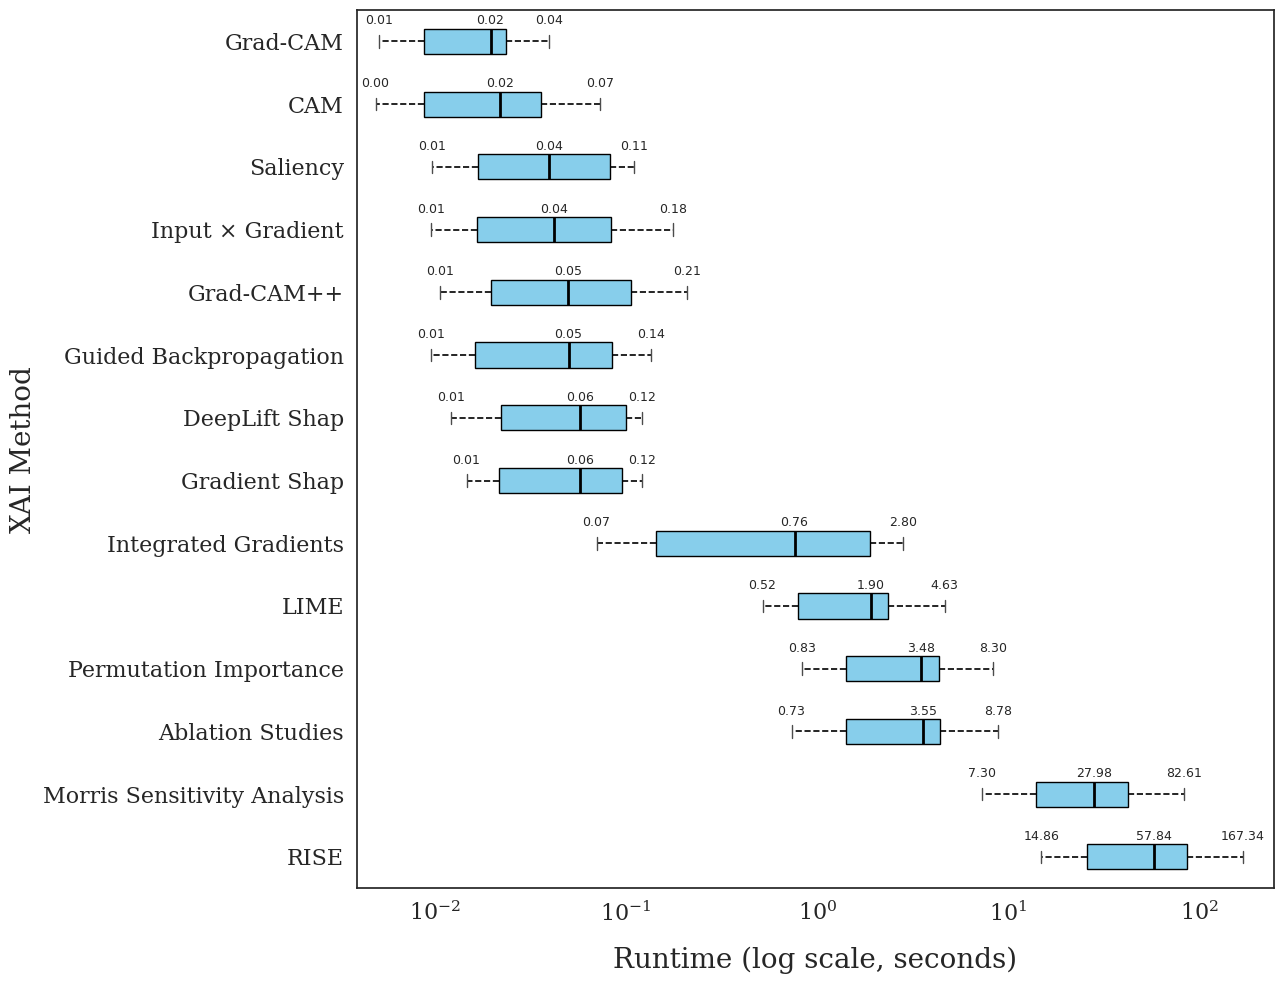

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import rcParams

# Set serif font globally (e.g., Computer Modern or Times New Roman)
rcParams["font.family"] = "serif"
rcParams["font.size"] = 12  # Set a base font size

# Ensure readable method names
df["method"] = df["method"].astype(str)
df["method_readable"] = df["method"].replace(method_name_map)
df = df.dropna(subset=["average_time"])

# Sort methods by median runtime
method_order = (
    df.groupby("method_readable")["average_time"]
    .median()
    .sort_values()
    .index
)

# Setup plot
fig, ax = plt.subplots(figsize=(13, 10))
sns.set_style("white")

# Boxplot
sns.boxplot(
    data=df,
    y="method_readable",
    x="average_time",
    order=method_order,
    orient="h",
    width=0.4,
    showcaps=True,
    showfliers=False,
    boxprops={"facecolor": "skyblue", "edgecolor": "black"},
    whiskerprops={"color": "black", "linestyle": "--", "linewidth": 1.2},  # <-- dashed whiskers!
    medianprops={"color": "black", "linewidth": 2},
    ax=ax
)


# Log scale and labels
ax.set_xscale("log")
ax.set_xlabel("Runtime (log scale, seconds)", labelpad=15, fontsize=20)
ax.set_ylabel("XAI Method", fontsize=20)
#ax.set_title("Runtime Distribution per XAI Method", pad=15, fontsize=18)

# REMOVE ALL grid lines
ax.grid(False)

ax.yaxis.set_tick_params(labelsize=16)
ax.xaxis.set_tick_params(labelsize=16)

# Remove minor log ticks
ax.xaxis.set_minor_formatter(plt.NullFormatter())


# Tighten x-axis limits to data range
x_min = df["average_time"].min()
x_max = df["average_time"].max()
ax.set_xlim(x_min * 0.8, x_max * 1.2)

# Annotate whisker-low, median, whisker-high with smart offsets
for i, method in enumerate(method_order):
    values = df[df["method_readable"] == method]["average_time"].dropna()
    q1 = np.percentile(values, 25)
    q2 = np.percentile(values, 50)
    q3 = np.percentile(values, 75)
    iqr = q3 - q1
    whis_low = values[values >= q1 - 1.5 * iqr].min()
    whis_high = values[values <= q3 + 1.5 * iqr].max()

    # Points to annotate
    points = [whis_low, q2, whis_high]
    labels = [f"{val:.2f}" for val in points]

    label_positions = []
    for idx, val in enumerate(points):
        x_shift = 0
        if idx > 0 and abs(np.log10(val) - np.log10(points[idx - 1])) < 0.08:
            x_shift = 25  # shift right if too close
        label_positions.append((val, x_shift))

    for (val, x_shift), label in zip(label_positions, labels):
        clipped_val = min(val, x_max * 0.98)  # stay inside plot
        ax.annotate(
            label,
            xy=(clipped_val, i),
            xytext=(x_shift, 10),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=9
        )

# Final layout and save
plt.tight_layout()
plt.savefig("figures/runtime_distributions_boxplot.png", dpi=300)
plt.show()
plt.close()

/tmp/ipykernel_3303/2966071422.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(
/tmp/ipykernel_3303/2966071422.py:47: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.8}` instead.

  barplot = sns.barplot(


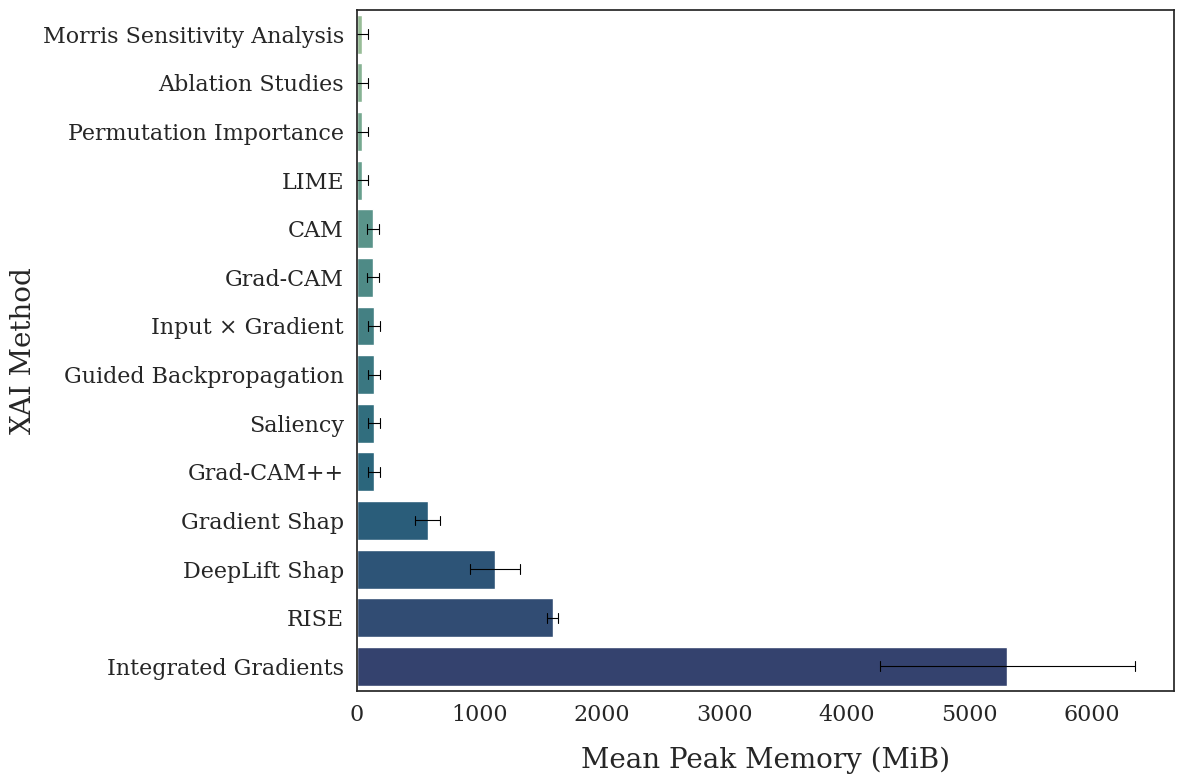

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

rcParams.update({
    "font.family": "serif",
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 14
})


# Method label mapping
method_labels = {
    "Grad_CAM": "Grad-CAM",
    "Grad_CAM_plus_plus": "Grad-CAM++",
    "Morris_Sensitivity_Analysis": "Morris Sensitivity Analysis",
    "GradientShap": "Gradient Shap",
    "IntegratedGradients": "Integrated Gradients",
    "PermutationImportance": "Permutation Importance",
    "DeepLiftShap": "DeepLift Shap",
    "InputXGradient": "Input × Gradient",
    "AblationStudies": "Ablation Studies",
    "GuidedBackprop": "Guided Backpropagation",
    "Saliency": "Saliency",
    "CAM": "CAM",
    "LIME": "LIME",
    "RISE": "RISE"
}

# Apply readable names
df["method_readable"] = df["method"].replace(method_labels)

# Sort by mean peak memory
mean_order = (
    df.groupby("method_readable")["average_peak_memory"]
    .mean()
    .sort_values()
    .index
)

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
sns.set_style("white")

barplot = sns.barplot(
    data=df,
    x="average_peak_memory",
    y="method_readable",
    order=mean_order,
    estimator="mean",
    errorbar="sd",
    palette="crest",
    capsize=0.2,
    errwidth=0.8,
    ax=ax
)

# Set error bar color for contrast
for line in barplot.lines:
    line.set_color("black")

# Labels and title
ax.set_xlabel("Mean Peak Memory (MiB)", labelpad=15, fontsize=20)
ax.set_ylabel("XAI Method", fontsize=20)
#ax.set_title("Mean Peak Memory Usage by XAI Method", pad=15)

ax.yaxis.set_tick_params(labelsize=16)
ax.xaxis.set_tick_params(labelsize=16)


# Start axis at 0
ax.set_xlim(left=0)

# Final layout
plt.tight_layout()
plt.savefig("figures/peak_memory_barplot.png", dpi=300)
plt.show()
plt.close()


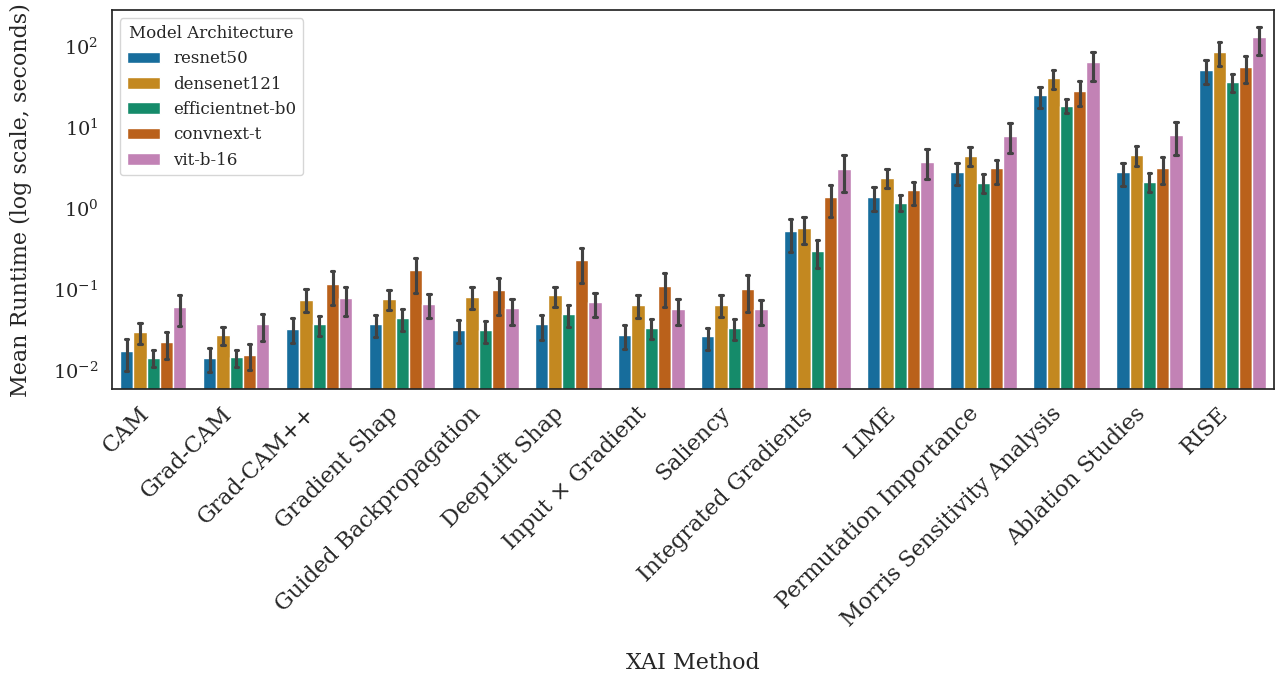

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

# Set serif font and sizing to match thesis style
rcParams.update({
    "font.family": "serif",
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 11,
    "legend.title_fontsize": 12
})

# Rename methods for clarity
df["method_readable"] = df["method"].replace({
    "Grad_CAM": "Grad-CAM",
    "Grad_CAM_plus_plus": "Grad-CAM++",
    "Morris_Sensitivity_Analysis": "Morris Sensitivity Analysis",
    "GradientShap": "Gradient Shap",
    "IntegratedGradients": "Integrated Gradients",
    "PermutationImportance": "Permutation Importance",
    "DeepLiftShap": "DeepLift Shap",
    "InputXGradient": "Input × Gradient",
    "AblationStudies": "Ablation Studies",
    "GuidedBackprop": "Guided Backpropagation",
    "Saliency": "Saliency",
    "CAM": "CAM",
    "LIME": "LIME",
    "RISE": "RISE"
})

# Seaborn clean style
sns.set_style("white")

# Plot
plt.figure(figsize=(13, 7))
ax = sns.barplot(
    data=df,
    x="method_readable",
    y="average_time",
    hue="model",
    palette="colorblind",
    capsize=0.2
)

rcParams["font.family"] = "serif"
# Log scale for runtime
ax.set_yscale("log")

# Axis labels
ax.set_xlabel("XAI Method", labelpad=15, fontsize=16, fontfamily="serif")
ax.set_ylabel("Mean Runtime (log scale, seconds)", labelpad=15, fontsize=16, fontfamily="serif")
#ax.set_title("Mean Runtime by XAI Method and Model Architecture", pad=15)

ax.yaxis.set_tick_params(labelsize=14)
ax.xaxis.set_tick_params(labelsize=16)
plt.setp(ax.get_xticklabels(), fontfamily="serif")
plt.setp(ax.get_yticklabels(), fontfamily="serif")

# Rotate x labels
plt.xticks(rotation=45, ha="right")

# Legend inside top-left
plt.legend(loc="upper left", title="Model Architecture", frameon=True, fontsize=12)

# Final layout and save
plt.tight_layout()
plt.savefig("figures/runtime_by_method.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

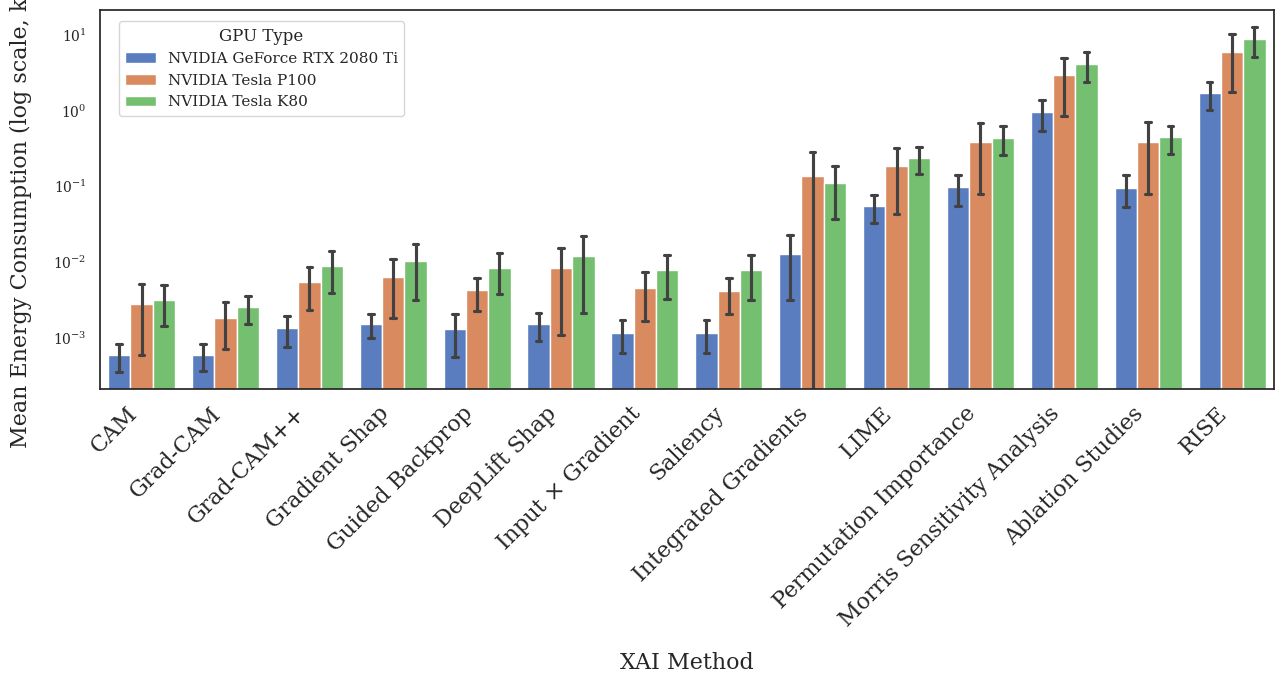

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

# Set serif font and sizes for thesis style
rcParams.update({
    "font.family": "serif",
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 11,
    "legend.title_fontsize": 12
})

# Rename methods for readability
df["XAI Method"] = df["method"].replace({
    "Grad_CAM": "Grad-CAM",
    "Grad_CAM_plus_plus": "Grad-CAM++",
    "Morris_Sensitivity_Analysis": "Morris Sensitivity Analysis",
    "GradientShap": "Gradient Shap",
    "IntegratedGradients": "Integrated Gradients",
    "PermutationImportance": "Permutation Importance",
    "DeepLiftShap": "DeepLift Shap",
    "InputXGradient": "Input × Gradient",
    "AblationStudies": "Ablation Studies",
    "GuidedBackprop": "Guided Backprop",
    "Saliency": "Saliency",
    "CAM": "CAM",
    "LIME": "LIME",
    "RISE": "RISE"
})

# Rename GPUs for readability
df["GPU Type"] = df["gpu_name"].replace({
    "K80": "NVIDIA Tesla K80",
    "P100": "NVIDIA Tesla P100",
    "RTX-2080-Ti": "NVIDIA GeForce RTX 2080 Ti"
})

# ENERGY: Barplot by GPU (log-scaled)
plt.figure(figsize=(13, 7))
sns.set_style("white")

ax = sns.barplot(
    data=df,
    x="XAI Method",
    y="energy_consumed_kWh",
    hue="GPU Type",
    palette="muted",
    estimator="mean",
    errorbar="sd",
    capsize=0.2
)

rcParams["font.family"] = "serif"

# Log scale
ax.set_yscale("log")

# Labels and title
ax.set_ylabel("Mean Energy Consumption (log scale, kWh)", labelpad=15, fontsize=16, fontfamily="serif")
ax.set_xlabel("XAI Method", labelpad=15, fontsize=16, fontfamily="serif")
#ax.set_title("Mean Energy Consumption by XAI Method and GPU Type", pad=15)

ax.yaxis.set_tick_params(labelsize=10)
ax.xaxis.set_tick_params(labelsize=16)
plt.setp(ax.get_xticklabels(), fontfamily="serif")
plt.setp(ax.get_yticklabels(), fontfamily="serif")

# Rotate X ticks
plt.xticks(rotation=45, ha="right")

# Legend inside top-left
plt.legend(title="GPU Type", loc="upper left", bbox_to_anchor=(0.01, 0.99))

# Layout and export
plt.tight_layout()
plt.savefig("figures/energy_by_gpu.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()


In [18]:
# Rename methods for readability
df["method_readable"] = df["method"].replace({
    "Grad_CAM": "Grad-CAM",
    "Grad_CAM_plus_plus": "Grad-CAM++",
    "Morris_Sensitivity_Analysis": "Morris Sensitivity Analysis",
    "GradientShap": "Gradient Shap",
    "IntegratedGradients": "Integrated Gradients",
    "PermutationImportance": "Permutation Importance",
    "DeepLiftShap": "DeepLift Shap",
    "InputXGradient": "Input X Gradient",
    "AblationStudies": "Ablation Studies",
    "GuidedBackprop": "Guided Backprop",
    "Saliency": "Saliency",
    "CAM": "CAM",
    "LIME": "LIME",
    "RISE": "RISE"
})

# Group directly by readable method and compute overall stats
summary = df.groupby("method_readable")["average_time"].agg(["mean", "std"]).reset_index()
summary = summary.sort_values("mean")
summary["mean"] = summary["mean"].round(2)
summary["std"] = summary["std"].round(2)

# Save to LaTeX table
latex_path = "tables/runtime_all_balanced.tex"
with open(latex_path, "w") as f:
    f.write("\\begin{table}[ht]\n\\centering\n")
    f.write("\\begin{tabular}{lcc}\n\\toprule\n")
    f.write("Method & Mean Runtime (s) & Std. Dev. (s) \\\\\n\\midrule\n")
    for _, row in summary.iterrows():
        f.write(f"{row['method_readable']} & {row['mean']:.2f} & {row['std']:.2f} \\\\\n")
    f.write("\\bottomrule\n\\end{tabular}\n")
    f.write("\\caption{Average runtime and standard deviation per XAI method across all configurations.}\n")
    f.write("\\label{tab:runtime_all_balanced}\n")
    f.write("\\end{table}\n")

print("✅ Table saved to", latex_path)
summary


✅ Table saved to tables/runtime_all_balanced.tex


,method_readable,mean,std
3,Grad-CAM,0.02,0.02
1,CAM,0.03,0.03
13,Saliency,0.06,0.05
7,Input X Gradient,0.06,0.05
6,Guided Backprop,0.06,0.05
4,Grad-CAM++,0.07,0.06
5,Gradient Shap,0.08,0.08
2,DeepLift Shap,0.10,0.10
8,Integrated Gradients,1.17,1.52
9,LIME,2.09,1.61


In [22]:

# Replace method names with readable ones
method_name_map = {
    "Grad_CAM": "Grad-CAM",
    "Grad_CAM_plus_plus": "Grad-CAM++",
    "Morris_Sensitivity_Analysis": "Morris Sensitivity Analysis",
    "GradientShap": "Gradient Shap",
    "IntegratedGradients": "Integrated Gradients",
    "PermutationImportance": "Permutation Importance",
    "DeepLiftShap": "DeepLift Shap",
    "InputXGradient": "Input X Gradient",
    "AblationStudies": "Ablation Studies",
    "GuidedBackprop": "Guided Backprop",
    "Saliency": "Saliency",
    "CAM": "CAM",
    "LIME": "LIME",
    "RISE": "RISE"
}
df["method_readable"] = df["method"].replace(method_name_map)

# Group by method and compute statistics
runtime_summary = df.groupby("method_readable")["average_time"].agg(["mean", "min", "max"]).reset_index()
runtime_summary["mean"] = runtime_summary["mean"].round(2)
runtime_summary["min"] = runtime_summary["min"].round(2)
runtime_summary["max"] = runtime_summary["max"].round(2)
runtime_summary = runtime_summary.sort_values("mean")

# Save LaTeX table
latex_path = "tables/runtime_all_minmax.tex"
with open(latex_path, "w") as f:
    f.write("\\begin{table}[ht]\n\\centering\n")
    f.write("\\begin{tabular}{lcc}\n\\toprule\n")
    f.write("Method & Mean Runtime (s) & Min--Max (s) \\\\\n\\midrule\n")
    for _, row in runtime_summary.iterrows():
        f.write(f"{row['method_readable']} & {row['mean']:.2f} & {row['min']:.2f}--{row['max']:.2f} \\\\\n")
    f.write("\\bottomrule\n\\end{tabular}\n")
    f.write("\\caption{Mean, minimum, and maximum runtime per XAI method across all configurations.}\n")
    f.write("\\label{tab:runtime_all_minmax}\n")
    f.write("\\end{table}\n")

latex_path


'tables/runtime_all_minmax.tex'

In [47]:
# Group by method and model to get average runtime
runtime_model_table = df.groupby(["method_readable", "model"])["average_time"].mean().unstack().round(4)

# Sort by average runtime over all models for clearer presentation
runtime_model_table["mean_over_models"] = runtime_model_table.mean(axis=1)
runtime_model_table = runtime_model_table.sort_values(by="mean_over_models").drop(columns=["mean_over_models"])

# Save as LaTeX table
latex_path = "tables/runtime_by_model_table.tex"
with open(latex_path, "w") as f:
    f.write("\\begin{table}[ht]\n\\centering\n")
    f.write("\\resizebox{\\textwidth}{!}{%\n")
    f.write(runtime_model_table.to_latex(index=True, float_format="%.3f"))
    f.write("}\n")
    f.write("\\caption{Average runtime (in seconds) for each XAI method across different model architectures.}\n")
    f.write("\\label{tab:runtime_by_model}\n")
    f.write("\\end{table}\n")

print("✅ LaTeX table saved to", latex_path)
runtime_model_table


✅ LaTeX table saved to tables/runtime_by_model_table.tex


model,convnext-t,densenet121,efficientnet-b0,resnet50,vit-b-16
method_readable,,,,,
Grad-CAM,0.0158,0.0277,0.0145,0.0143,0.0373
CAM,0.0224,0.0303,0.0142,0.0175,0.0611
Saliency,0.1017,0.0645,0.0335,0.0266,0.0574
Input X Gradient,0.1097,0.0652,0.0332,0.0274,0.0578
Guided Backprop,0.0980,0.0815,0.0317,0.0319,0.0584
Grad-CAM++,0.1178,0.0751,0.0370,0.0330,0.0791
Gradient Shap,0.1722,0.0773,0.0441,0.0380,0.0670
DeepLift Shap,0.2328,0.0851,0.0494,0.0372,0.0708
Integrated Gradients,1.3940,0.5817,0.2950,0.5247,3.0465


In [5]:


# ========== FULL MEMORY TABLE ==========
memory_summary = df.groupby("method")["average_peak_memory"].agg(["mean", "std"]).reset_index()
memory_summary = memory_summary.sort_values("mean")

save_latex_table(memory_summary, "memory_all.tex",
                 "Average peak memory usage and standard deviation for all XAI methods.",
                 "tab:memory_all", ["Peak Memory (MiB)", "Std. Dev. (MiB)"])


# ========== FULL ENERGY TABLE ==========
energy_summary = df.groupby("method")["energy_consumed_kWh"].agg(["mean", "std"]).reset_index()
energy_summary = energy_summary.sort_values("mean")

save_latex_table(energy_summary, "energy_all.tex",
                 "Average energy consumption and standard deviation for all XAI methods.",
                 "tab:energy_all", ["Energy (kWh)", "Std. Dev. (kWh)"])


# ========== PLOT: Log-Scaled Runtime by Method ==========
plt.figure(figsize=(12, 6))
sns.barplot(data=runtime_summary, x="method", y="mean", palette="viridis")
plt.yscale("log")
plt.ylabel("Average Runtime (log scale, s)")
plt.title("Log-Scaled Average Runtime per XAI Method")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("figures/runtime_log_barplot.png", dpi=300)
plt.close()


# ========== PLOT: Violin Plot for Peak Memory ==========
plt.figure(figsize=(12, 6))
sns.violinplot(data=df, x="method", y="average_peak_memory", scale="width", inner="quartile", palette="pastel")
plt.ylabel("Peak Memory Usage (MiB)")
plt.title("Distribution of Peak Memory Usage by XAI Method")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("figures/violin_peak_memory_usage.png", dpi=300)
plt.close()


# ========== PLOT: Energy vs Runtime (Outlier Identifier) ==========
avg_energy_time = df.groupby("method")[["average_time", "energy_consumed_kWh"]].mean().reset_index()

plt.figure(figsize=(10, 7))
sns.scatterplot(data=avg_energy_time, x="average_time", y="energy_consumed_kWh", s=100)

for _, row in avg_energy_time.iterrows():
    plt.annotate(row["method"], (row["average_time"], row["energy_consumed_kWh"]),
                 textcoords="offset points", xytext=(4, 4), fontsize=9)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Average Runtime (s, log scale)")
plt.ylabel("Energy Consumption (kWh, log scale)")
plt.title("Energy vs. Runtime (Log-Log, Outlier Detection)")
plt.tight_layout()
plt.savefig("figures/energy_vs_runtime_outlier_scatter.png", dpi=300)
plt.close()



# ========== RUNTIME BY DATASET ==========
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="dataset", y="average_time", hue="method")
plt.yscale("log")
plt.ylabel("Average Runtime (log scale, s)")
plt.title("Runtime by Dataset and XAI Method")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("figures/runtime_by_dataset.png", dpi=300)
plt.close()


# ========== RUNTIME BY GPU ==========
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="method", y="average_time", hue="gpu_name")
plt.yscale("log")
plt.ylabel("Average Runtime (log scale, s)")
plt.title("Runtime by XAI Method and GPU")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("figures/runtime_by_gpu.png", dpi=300)
plt.close()


# ========== ENERGY CONSUMPTION BY GPU TABLE ==========
energy_gpu = df.groupby(["method", "gpu_name"])["energy_consumed_kWh"].mean().unstack()
energy_gpu.T.to_latex("tables/energy_by_gpu.tex", float_format="%.5f")

"✅ All comprehensive figures and LaTeX tables have been saved in 'figures/' and 'tables/'."



/tmp/ipykernel_565/3996382414.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=runtime_summary, x="method", y="mean", palette="viridis")
/tmp/ipykernel_565/3996382414.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="method", y="average_peak_memory", scale="width", inner="quartile", palette="pastel")
/tmp/ipykernel_565/3996382414.py:81: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=df, x="method", y="average_peak_memory", scale="width", inner="quartile", palette="pastel")


"✅ All comprehensive figures and LaTeX tables have been saved in 'figures/' and 'tables/'."

In [6]:
# Comprehensive code to generate ALL relevant figures and tables
# for runtime, memory, and energy, by method, model, dataset, and GPU.
# This code will save all assets for \chapter{Results} in LaTeX.

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# Load and prepare
sns.set(style="whitegrid")
df = pd.read_json("summary.jsonl", lines=True)

# Ensure correct dtypes
for col in ["average_time", "std_time", "average_peak_memory", "std_peak_memory",
            "average_net_memory_change", "std_net_memory_change", "energy_consumed_kWh"]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Create folders
os.makedirs("figures", exist_ok=True)
os.makedirs("tables", exist_ok=True)

# ========== HELPER: Save LaTeX Tables ==========

def save_latex_table_format(df_table, filename, caption, label, col_labels, float_format):
    with open(f"tables/{filename}", "w") as f:
        f.write("\\begin{table}[ht]\n\\centering\n")
        f.write("\\begin{tabular}{lcc}\n\\hline\n")
        f.write(f"Method & {col_labels[0]} & {col_labels[1]} \\\\\n\\hline\n")
        for _, row in df_table.iterrows():
            f.write(f"{row['method']} & {float_format.format(row['mean'])} & {float_format.format(row['std'])} \\\\\n")
        f.write("\\hline\n\\end{tabular}\n")
        f.write(f"\\caption{{{caption}}}\n")
        f.write(f"\\label{{{label}}}\n")
        f.write("\\end{table}\n")

# ========== TABLES: Runtime, Memory, Energy ==========

runtime_summary = df.groupby("method")["average_time"].agg(["mean", "std"]).reset_index().sort_values("mean")
save_latex_table_format(runtime_summary, "runtime_all.tex", "Average runtime and standard deviation for all XAI methods.",
                        "tab:runtime_all", ["Mean Runtime (s)", "Std. Dev. (s)"], float_format="{:.2f}")

memory_summary = df.groupby("method")["average_peak_memory"].agg(["mean", "std"]).reset_index().sort_values("mean")
save_latex_table_format(memory_summary, "memory_all.tex", "Average peak memory usage and standard deviation for all XAI methods.",
                        "tab:memory_all", ["Peak Memory (MiB)", "Std. Dev. (MiB)"], float_format="{:.0f}")

energy_summary = df.groupby("method")["energy_consumed_kWh"].agg(["mean", "std"]).reset_index().sort_values("mean")
save_latex_table_format(energy_summary, "energy_all.tex", "Average energy consumption and standard deviation for all XAI methods.",
                        "tab:energy_all", ["Energy (kWh)", "Std. Dev. (kWh)"], float_format="{:.2f}")

# Pivoted table: Energy per GPU
pivot_energy = df.pivot_table(index="gpu_name", columns="method", values="energy_consumed_kWh", aggfunc="mean").round(2)
pivot_energy.to_latex("tables/energy_by_gpu.tex", float_format="%.2f")

# ========== FIGURES ==========

# RUNTIME: Log-bar
plt.figure(figsize=(12, 6))
sns.barplot(data=runtime_summary, x="method", y="mean", palette="viridis")
plt.yscale("log")
plt.ylabel("Avg. Runtime (log scale, s)")
plt.title("Log-Scaled Average Runtime per XAI Method")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("figures/runtime_log_barplot.png", dpi=300)
plt.close()

# ENERGY: Better heatmap-style overview
pivot_energy_plot = pivot_energy.fillna(0)
plt.figure(figsize=(14, 5))
sns.heatmap(pivot_energy_plot, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Energy (kWh)'})
plt.title("Energy Consumption per Method and GPU")
plt.xlabel("XAI Method")
plt.ylabel("GPU")
plt.tight_layout()
plt.savefig("figures/heatmap_energy_by_gpu.png", dpi=300)
plt.close()


# RUNTIME: By GPU
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="method", y="average_time", hue="gpu_name")
plt.yscale("log")
plt.ylabel("Average Runtime (log scale, s)")
plt.title("Runtime by XAI Method and GPU")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("figures/runtime_by_gpu.png", dpi=300)
plt.close()


"✅ All tables and figures for runtime, memory, and energy have been generated and saved to 'tables/' and 'figures/' folders."



/tmp/ipykernel_565/2254645083.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=runtime_summary, x="method", y="mean", palette="viridis")
/tmp/ipykernel_565/2254645083.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="method", y="average_peak_memory", scale="width", inner="quartile", palette="pastel")
/tmp/ipykernel_565/2254645083.py:71: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=df, x="method", y="average_peak_memory", scale="width", inner="quartile", palette="pastel")


"✅ All tables and figures for runtime, memory, and energy have been generated and saved to 'tables/' and 'figures/' folders."

In [ ]:
# --- Setup ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# Set seaborn style
sns.set(style="whitegrid")

# Load the data
df = pd.read_json("summary.jsonl", lines=True)


# Pivot runtime data: average_time grouped by method and dataset
runtime_pivot = df.groupby(["method", "dataset"])["average_time"].mean().unstack()

# Optional: round for readability
runtime_pivot_rounded = runtime_pivot.round(2)

# Sort methods by average runtime (ImageNet as anchor column)
runtime_pivot_rounded = runtime_pivot_rounded.sort_values(by="ImageNet")

# Save as LaTeX table
latex_path = "tables/runtime_by_dataset.tex"
with open(latex_path, "w") as f:
    f.write("\\begin{table}[ht]\n\\centering\n")
    f.write("\\begin{tabular}{lccc}\n\\toprule\n")
    f.write("Method & CIFAR10 & STL10 & ImageNet \\\\\n\\midrule\n")
    for method, row in runtime_pivot_rounded.iterrows():
        f.write(f"{method} & {row['CIFAR10']:.2f} & {row['STL10']:.2f} & {row['ImageNet']:.2f} \\\\\n")
    f.write("\\bottomrule\n\\end{tabular}\n")
    f.write("\\caption{Average runtime (in seconds) per dataset for each XAI method.}\n")
    f.write("\\label{tab:runtime_by_dataset}\n")
    f.write("\\end{table}\n")

print("✅ LaTeX table saved to", latex_path)
runtime_pivot_rounded

In [ ]:
# Pivot runtime and energy data grouped by method and GPU
runtime_pivot = df.groupby(["method", "gpu_name"])["average_time"].mean().unstack()
energy_pivot = df.groupby(["method", "gpu_name"])["energy_consumed_kWh"].mean().unstack()

# Round for readability
runtime_pivot = runtime_pivot.round(2)
energy_pivot = energy_pivot.round(2)

# Sort by runtime on RTX-2080-Ti (or change to P100/K80 if preferred)
runtime_pivot = runtime_pivot.sort_values(by="RTX-2080-Ti")
energy_pivot = energy_pivot.loc[runtime_pivot.index]  # Align rows

# Save combined LaTeX table
latex_combined_path = "tables/runtime_energy_by_gpu.tex"
with open(latex_combined_path, "w") as f:
    f.write("\\begin{table}[ht]\n\\centering\n")
    f.write("\\resizebox{\\textwidth}{!}{%\n")
    f.write("\\begin{tabular}{lccc|ccc}\n\\toprule\n")
    f.write("Method & \\multicolumn{3}{c|}{Runtime (s)} & \\multicolumn{3}{c}{Energy (kWh)} \\\\\n")
    f.write(" & RTX 2080 Ti & P100 & K80 & RTX 2080 Ti & P100 & K80 \\\\\n\\midrule\n")

    for method in runtime_pivot.index:
        method_name = method.replace("_", " ")
        rt_rtx, rt_p100, rt_k80 = runtime_pivot.loc[method]
        en_rtx, en_p100, en_k80 = energy_pivot.loc[method]
        f.write(f"{method_name} & {rt_rtx:.2f} & {rt_p100:.2f} & {rt_k80:.2f} & {en_rtx:.2f} & {en_p100:.2f} & {en_k80:.2f} \\\\\n")

    f.write("\\bottomrule\n\\end{tabular}}\n")
    f.write("\\caption{Combined average runtime and energy consumption (TDP-based) per GPU for each XAI method.}\n")
    f.write("\\label{tab:runtime_energy_by_gpu}\n")
    f.write("\\end{table}\n")

print("✅ Combined LaTeX table saved to:", latex_combined_path)
